In [1]:
import logging
logging.getLogger().setLevel(logging.ERROR)
from pathlib import Path
from docembedder.utils import SimulationSpecification
from docembedder.utils import run_models
from docembedder.preprocessor import Preprocessor
from docembedder.models import CountVecEmbedder
from docembedder.models import TfidfEmbedder
from docembedder.models import D2VEmbedder
from docembedder.models import BERTEmbedder
from docembedder import DataModel
from docembedder.analysis import DocAnalysis
from docembedder.pretrained_run import pretrained_run_models
from configparser import ConfigParser

In [2]:
# set simulation specification
sim_spec = SimulationSpecification(
    year_start=1838,
    year_end=1951,
    window_size=21,
    window_shift=1,
    debug_max_patents=100,
)

In [3]:
# read local config
config = ConfigParser()
_ = config.read("setup.ini")
patent_dir = Path(config["DATA"]["patent_dir"])
output_fp = Path(config["DATA"]["output_dir"], "patents.h5")
cpc_fp = Path(config["DATA"]["cpc_file"])


In [4]:
model_cv = {
    "countvec": CountVecEmbedder(method='sigmoid'),
}
model_tfidf = {
    "tfidf": TfidfEmbedder(ngram_max=1,stop_words='english',stem=True, norm='l1', sublinear_tf=True, min_df=6, max_df=0.665461),
}
model_dv = {
    "doc2vec":D2VEmbedder(epoch=9, min_count=7, vector_size=101),
}
model_bert = {
    "bert":BERTEmbedder(pretrained_model='AI-Growth-Lab/PatentSBERTa'),
}

In [5]:
preprocessor_cv = {
    "prep-countvec": Preprocessor(keep_caps=False, keep_start_section=False, remove_non_alpha=True),
}
preprocessor_tfidf = {
    "prep-tfidf": Preprocessor(keep_caps=True, keep_start_section=True, remove_non_alpha=True),
   }
preprocessor_dv = {
    "prep-doc2vec": Preprocessor(keep_caps=False, keep_start_section=True, remove_non_alpha=False),
}
preprocessor_bert = {
     "prep-bert": Preprocessor(keep_caps=True, keep_start_section=True, remove_non_alpha=True),
}

In [6]:
%%time
# Calculate embeddings
run_models(preprocessor_cv, model_cv, sim_spec, patent_dir, output_fp, cpc_fp, n_jobs=8)
run_models(preprocessor_tfidf, model_tfidf, sim_spec, patent_dir, output_fp, cpc_fp, n_jobs=8)
run_models(preprocessor_dv, model_dv, sim_spec, patent_dir, output_fp, cpc_fp, n_jobs=8)
pretrained_run_models(preprocessor_bert, model_bert, sim_spec, patent_dir, output_fp, cpc_fp)

CPU times: user 434 ms, sys: 8.95 ms, total: 443 ms
Wall time: 442 ms


372it [03:25,  1.81it/s]


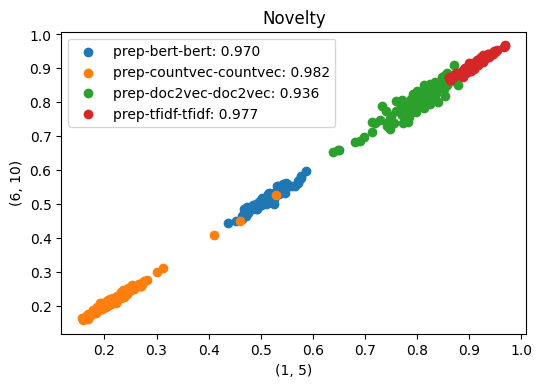

In [9]:
from docembedder.visualization import plot_cpc_correlations, plot_window_difference
from docembedder.analysis import DocAnalysis
from matplotlib import pyplot as plt
import numpy as np

with DataModel(output_fp, read_only=False) as data:
    analysis = DocAnalysis(data)
    correlations = analysis.cpc_correlations()
    # plot_cpc_correlations(correlations)
    plot_window_difference(analysis, (1, 5), (6, 10), impact=False)



In [8]:
#%%time
## Calculate impacts and novelties
#with DataModel(output_fp, read_only=False) as data:
#    analysis = DocAnalysis(data)
#    for window, model in data.iterate_window_models():
#        impact = analysis.patent_impacts(window, model)
#        novelty = analysis.patent_novelties(window, model)